In [1]:
id_ = 'Zilionis_Klein_2019_NSCLC'
# id = 'Lambrechts_2018_LUAD_6149v1'
backup_dir = '/root/datos/maestria/netopaas/luca_explore/surgeries'
infercnv_dir = '/root/datos/maestria/netopaas/infercnv'
ikarus_dir = '/root/datos/maestria/netopaas/ikarus'
load_wilcoxon = True
load_gsea = True
load_gsea_heatmap = False
run_umap = False

In [2]:
# Parameters
id_ = "He_Fan_2021_LUAD"


# Cell Type Verification

## Libraries and Data

We want to check our tumor vs normal classifier. For that we will explore the state of our cells by different methods.

1. Via UMAP, how the types of cell cluster vs the tumor and normal labels. Also, if it is normal adjacent or tumor. Sample labels to discard batch effects.
2. Marker genes plots for these comparisons per cell type: (**TypeNormalPred_HT** vs **REST**) (**TypeNormalPred_TT** vs **REST**) (**TypeNormalPred_HT** vs **TypeNormalPred_TT**)
   (**TypeTumorPred_TT** vs **REST**) (**TypeTumorPred_TT** vs **TypeNormalPred_TT**)
3. Heatmaps With the above groups (**TumorPred_TT**, **NormalPred_TT**, **NormalPred_HT**) as  cell labels and hierarchical clustering in the genes. With genes chosen from the marker genes.
4. Prevalent gene ontologies for each of the groups above, considering also hallmark ontologies

In [3]:
import os
from pathlib import Path
import gdown

import sys
# This makes the working dir change apparently
sys.path.append("..")
import utils.functions as ut

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

In [4]:
# adata = sc.read_h5ad(f'{backup_dir}/combTumor_{id_}.h5ad')
adata = sc.read_h5ad(f'{backup_dir}/filtered_{id_}.h5ad')
adata

AnnData object with n_obs × n_vars = 113612 × 26833
    obs: 'dataset', 'accession', 'sample', 'origin', 'tissue', 'age', 'sex', 'patient', 'condition', 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito'
    var: 'n_counts', 'mito', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Types from infercnv dir

In [5]:
types = pd.read_csv(f'{infercnv_dir}/{id_}.csv')
types = types.rename(columns={'Unnamed: 0':'barcode_'})
types = types.rename(columns={'Level_2_transfered_label':'cell_type'})
types

,barcode_,cell_type
0,AAACCTGAGACTGTAA-1_0,Lymphoid
1,AAACCTGAGCACCGTC-1_0,Myeloid
2,AAACCTGAGCCGCCTA-1_0,Lymphoid
3,AAACCTGAGCGATCCC-1_0,Lymphoid
4,AAACCTGAGCGTTGCC-1_0,Lymphoid
...,...,...
113607,TTTGTCATCAGTGTTG-1_9,Alveolar epithelium
113608,TTTGTCATCCCTTGCA-1_9,Lymphoid
113609,TTTGTCATCGTAGATC-1_9,Alveolar epithelium
113610,TTTGTCATCTACCTGC-1_9,Alveolar epithelium


In [6]:
adata.obs['barcode_'] = adata.obs.index
adata.obs = pd.merge(adata.obs, types, on='barcode_',
                    how='left')
adata.obs.cell_type = adata.obs.cell_type.fillna('Unknown')
adata.obs.columns

Index(['dataset', 'accession', 'sample', 'origin', 'tissue', 'age', 'sex',
       'patient', 'condition', 'n_counts', 'n_genes', 'n_genes_by_counts',
       'total_counts', 'total_counts_mito', 'pct_counts_mito', 'barcode_',
       'cell_type'],
      dtype='object')

### Tumor prediction from ikarus

In [7]:
preds = pd.read_csv(f'{ikarus_dir}/{id_}.csv')
preds

,Unnamed: 0,final_pred
0,0,Normal
1,1,Normal
2,2,Normal
3,3,Normal
4,4,Normal
...,...,...
113607,113607,Normal
113608,113608,Normal
113609,113609,Normal
113610,113610,Normal


In [8]:
adata.obs['final_pred'] = list(preds.iloc[:,1])

In [9]:
adata.obs['origin']

0           tumor_primary
1           tumor_primary
2           tumor_primary
3           tumor_primary
4           tumor_primary
               ...       
113607    normal_adjacent
113608    normal_adjacent
113609    normal_adjacent
113610    normal_adjacent
113611    normal_adjacent
Name: origin, Length: 113612, dtype: category
Categories (2, object): ['normal_adjacent', 'tumor_primary']

In [10]:
adata[np.logical_or(adata.obs['origin'].str.contains('normal'), adata.obs['origin']=='tumor_primary')].obs['origin'].value_counts()

origin
normal_adjacent    60271
tumor_primary      53341
Name: count, dtype: int64

In [11]:
adata.layers['counts'] = adata.X

In [12]:
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

## UMAP Clusters

We see similarities between cell types in normal tisse and tumor tissue. And  also what cell types are tumoral.

In [13]:
#papermill_description=UMAP
if run_umap:
    sc.tl.pca(adata)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)

In [14]:
if run_umap:
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    sc.pl.umap(
        adata,
        color="cell_type",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="final_pred",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[0, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="origin",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 0],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    sc.pl.umap(
        adata,
        color="sample",
        # legend_loc="on data",
        legend_fontoutline=2,
        ax=axs[1, 1],  # Specifies the subplot
        show=False  # Prevents showing the plot immediately
    )
    
    # Display the entire figure with all plots
    plt.tight_layout()
    plt.show()

We can see that for the 'Tumor' prediciton there are mostly cells from patient 41, although there are many more samples from primary tumor.
This could be due to batch effects. So it is worthwile to run the prediction again with batch correction.

In [15]:
# adata.obs.groupby('leiden').count()
adata.obs.groupby('sample').count().iloc[:,0]

/tmp/ipykernel_27778/2910804369.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby('sample').count().iloc[:,0]


sample
LUAD1    13268
LUAD2    10233
LUAD3    11527
LUAD4    11038
LUAD5     7275
N1       13777
N2       10927
N3        9749
N4       15687
N5       10131
Name: dataset, dtype: int64

## Marker Genes

Create a column that merges cell type, tissue and tumor pred

In [16]:
adata.obs['type_tissue'] = adata.obs.apply(lambda x: str(x['cell_type']) + '_' + 
                 ('HT' if 'normal' in x['origin'] else 'TT') + 
                 '_' + x['final_pred'], axis=1)
adata.obs['type_tissue'] = adata.obs['type_tissue'].astype('category')
adata.obs['type_tissue']

0                    Lymphoid_TT_Normal
1                     Myeloid_TT_Normal
2                    Lymphoid_TT_Normal
3                    Lymphoid_TT_Normal
4                    Lymphoid_TT_Normal
                      ...              
113607    Alveolar epithelium_HT_Normal
113608               Lymphoid_HT_Normal
113609    Alveolar epithelium_HT_Normal
113610    Alveolar epithelium_HT_Normal
113611                Unknown_HT_Normal
Name: type_tissue, Length: 113612, dtype: category
Categories (25, object): ['Airway epithelium_HT_Normal', 'Airway epithelium_HT_Tumor', 'Airway epithelium_TT_Normal', 'Alveolar epithelium_HT_Normal', ..., 'Submucosal Gland_HT_Normal', 'Unknown_HT_Normal', 'Unknown_HT_Tumor', 'Unknown_TT_Normal']

In [17]:
# We dont get them with unique because it saves the NaN's
adata.obs.cell_type = adata.obs.cell_type.astype('category')
types = adata.obs.cell_type.cat.categories
num_types = len(types)
types

Index(['Airway epithelium', 'Alveolar epithelium', 'Blood vessels',
       'Fibroblast lineage', 'Lymphatic EC', 'Lymphoid', 'Mesothelium',
       'Myeloid', 'Smooth muscle', 'Submucosal Gland', 'Unknown'],
      dtype='object')

In [18]:
adata.obs['type_tissue'].value_counts()

type_tissue
Myeloid_TT_Normal                27204
Myeloid_HT_Normal                20046
Lymphoid_TT_Normal               16522
Lymphoid_HT_Normal               16263
Alveolar epithelium_HT_Normal     8118
Unknown_HT_Normal                 7248
Airway epithelium_HT_Normal       6875
Alveolar epithelium_TT_Normal     3016
Airway epithelium_TT_Normal       2928
Blood vessels_TT_Normal           1402
Unknown_TT_Normal                  938
Fibroblast lineage_TT_Normal       852
Fibroblast lineage_HT_Normal       702
Blood vessels_HT_Normal            589
Lymphatic EC_TT_Normal             243
Alveolar epithelium_HT_Tumor       208
Mesothelium_TT_Normal              193
Lymphatic EC_HT_Normal              92
Smooth muscle_HT_Normal             73
Smooth muscle_TT_Normal             43
Unknown_HT_Tumor                    40
Airway epithelium_HT_Tumor          11
Myeloid_HT_Tumor                     3
Lymphoid_HT_Tumor                    2
Submucosal Gland_HT_Normal           1
Name: count, 

In [19]:
#papermill_description=WILCOXON_DE
# Get the groups that have more than 2 cells associated with them
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)
w_folder = 'wilcoxon_DE'

# Load

all_path = f'{w_folder}/all_{id_}.npy'
key = "wilcoxon"

if load_wilcoxon:
    adata.uns[key] = np.load(all_path, allow_pickle='TRUE').item()
else:
    sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = key,
                       groups=valid_types)
    np.save(all_path, adata.uns[key])

for type in types:
    tumor_tumor = type + '_TT_Tumor'
    normal_tumor = type + '_TT_Normal'
    normal_healthy = type + '_HT_Normal'

    differ_key = f"w_pair_{type}_differ"
    normal_key = f"w_pair_{type}_normal"
    differ_path =  f'{w_folder}/{differ_key}.npy'
    normal_path = f'{w_folder}/{normal_key}.npy'
    if load_wilcoxon:
        # We check for existance  here and not up there because there some datasets with no normal tissue
        if os.path.exists(differ_path):
            adata.uns[differ_key] = np.load(differ_path, allow_pickle='TRUE').item()
        if os.path.exists(normal_path):
            adata.uns[normal_key] = np.load(normal_path, allow_pickle='TRUE').item()
    else:
        if set([tumor_tumor, normal_tumor]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = differ_key,
                                    groups=[tumor_tumor], reference=normal_tumor)
            np.save(differ_path, adata.uns[differ_key])
            
        if set([normal_tumor, normal_healthy]).issubset(valid_types):
            sc.tl.rank_genes_groups(adata, 'type_tissue', method='wilcoxon', key_added = normal_key,
                                    groups=[normal_tumor], reference=normal_healthy)
            np.save(normal_path, adata.uns[normal_key])

In [20]:
def cond_plot(adata, cond_types, valid_types, ax=None,
              key='wilcoxon', fontsize=9, titlesize=14, **kwds):
    print(cond_types)
    if set(cond_types).issubset(valid_types):
        ut.rank_genes_group(adata, cond_types[0], n_genes=n_genes,
                            ax=ax, sharey=False, key=key, show=False,
                            fontsize=fontsize, titlesize=titlesize)
    else:
        # Draw an empty plot with a message
        ax.text(0.5, 0.5, f'Missing cells: {cond_types}', color='red', 
                       ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

In [21]:
valid_types

['Myeloid_TT_Normal',
 'Myeloid_HT_Normal',
 'Lymphoid_TT_Normal',
 'Lymphoid_HT_Normal',
 'Alveolar epithelium_HT_Normal',
 'Unknown_HT_Normal',
 'Airway epithelium_HT_Normal',
 'Alveolar epithelium_TT_Normal',
 'Airway epithelium_TT_Normal',
 'Blood vessels_TT_Normal',
 'Unknown_TT_Normal',
 'Fibroblast lineage_TT_Normal',
 'Fibroblast lineage_HT_Normal',
 'Blood vessels_HT_Normal',
 'Lymphatic EC_TT_Normal',
 'Alveolar epithelium_HT_Tumor',
 'Mesothelium_TT_Normal',
 'Lymphatic EC_HT_Normal',
 'Smooth muscle_HT_Normal',
 'Smooth muscle_TT_Normal',
 'Unknown_HT_Tumor',
 'Airway epithelium_HT_Tumor',
 'Myeloid_HT_Tumor']

['Airway epithelium_TT_Tumor']
['Airway epithelium_TT_Tumor', 'Airway epithelium_TT_Normal']
['Alveolar epithelium_TT_Tumor']
['Alveolar epithelium_TT_Tumor', 'Alveolar epithelium_TT_Normal']
['Blood vessels_TT_Tumor']
['Blood vessels_TT_Tumor', 'Blood vessels_TT_Normal']
['Fibroblast lineage_TT_Tumor']
['Fibroblast lineage_TT_Tumor', 'Fibroblast lineage_TT_Normal']
['Lymphatic EC_TT_Tumor']
['Lymphatic EC_TT_Tumor', 'Lymphatic EC_TT_Normal']
['Lymphoid_TT_Tumor']
['Lymphoid_TT_Tumor', 'Lymphoid_TT_Normal']
['Mesothelium_TT_Tumor']
['Mesothelium_TT_Tumor', 'Mesothelium_TT_Normal']
['Myeloid_TT_Tumor']
['Myeloid_TT_Tumor', 'Myeloid_TT_Normal']
['Smooth muscle_TT_Tumor']
['Smooth muscle_TT_Tumor', 'Smooth muscle_TT_Normal']
['Submucosal Gland_TT_Tumor']
['Submucosal Gland_TT_Tumor', 'Submucosal Gland_TT_Normal']
['Unknown_TT_Tumor']
['Unknown_TT_Tumor', 'Unknown_TT_Normal']


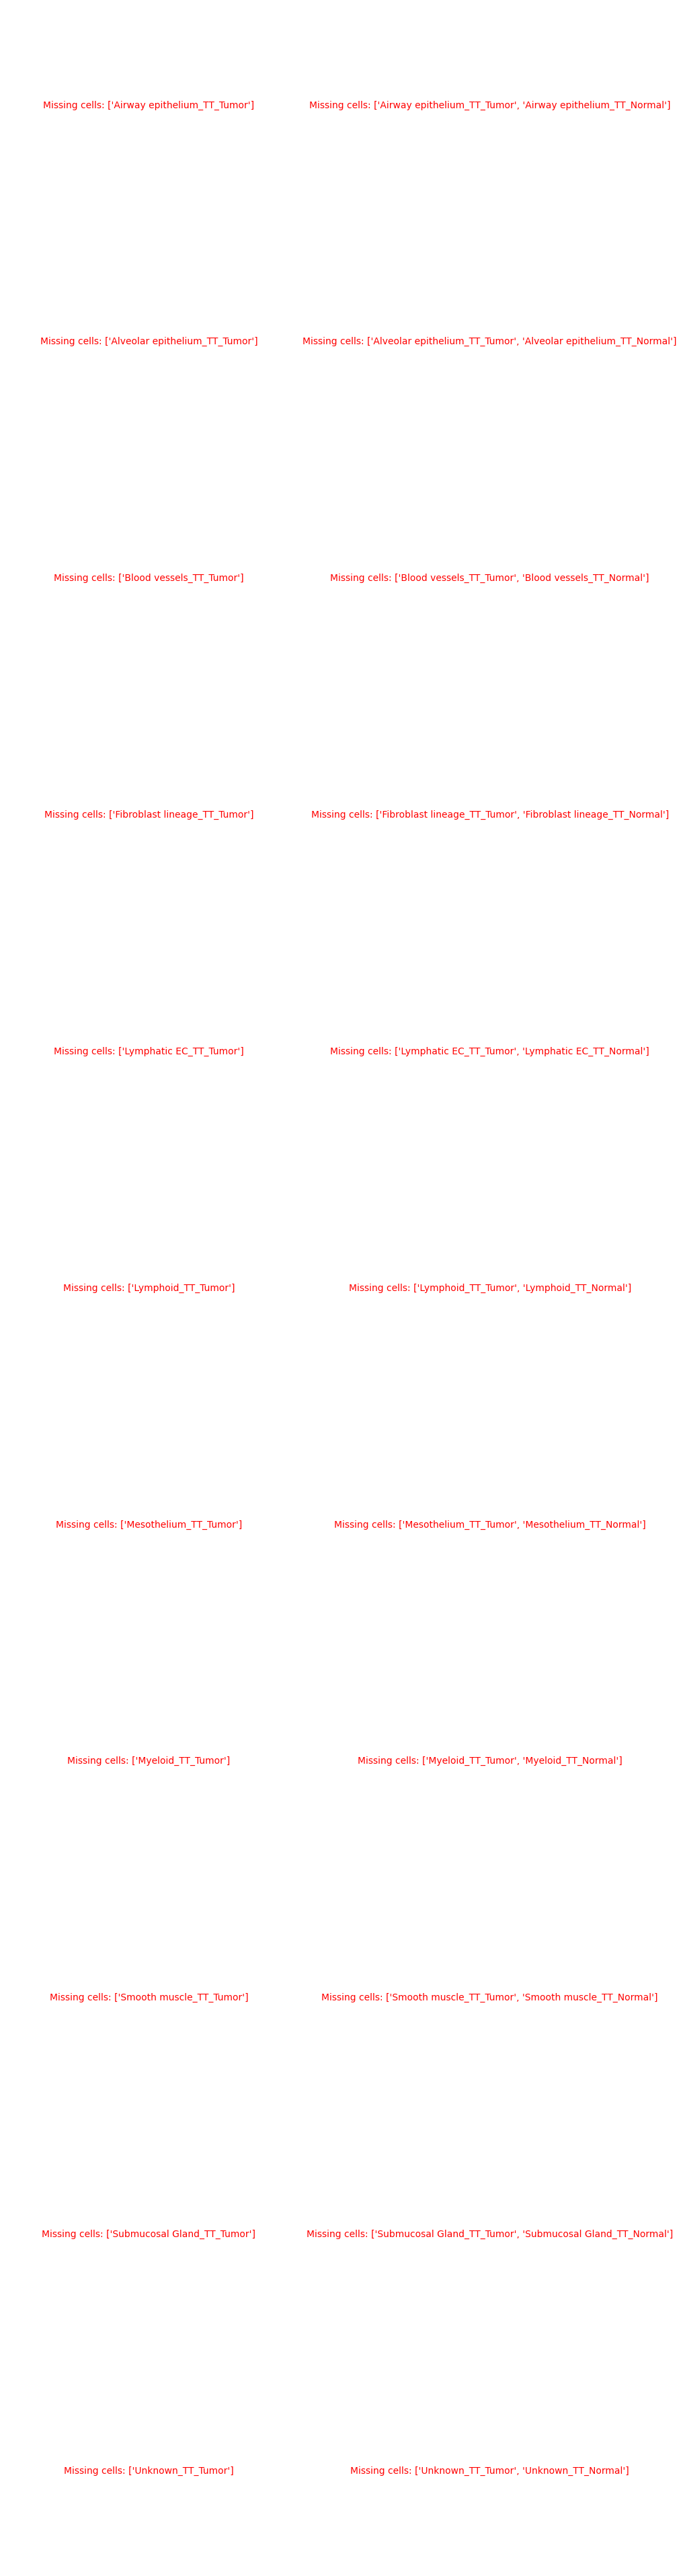

In [22]:
if(adata.obs.origin.str.contains('tumor').any()):
    fig, axs = plt.subplots(num_types, 2, figsize=(12, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        tumor_tumor = type + '_TT_Tumor'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [tumor_tumor], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [tumor_tumor, normal_tumor], valid_types, n_genes=n_genes, ax= axs[i, 1],
                                key=f"w_pair_{type}_differ", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    from warnings import warn
    warn('NO TUMOR TISSUES!?!?!?!!?')

In [23]:
adata.obs.origin.str.contains('normal').any()

True

['Airway epithelium_HT_Normal']
['Airway epithelium_TT_Normal']
w_pair_Airway epithelium_normal
['Airway epithelium_TT_Normal', 'Airway epithelium_HT_Normal']
['Alveolar epithelium_HT_Normal']
['Alveolar epithelium_TT_Normal']
w_pair_Alveolar epithelium_normal
['Alveolar epithelium_TT_Normal', 'Alveolar epithelium_HT_Normal']
['Blood vessels_HT_Normal']
['Blood vessels_TT_Normal']
w_pair_Blood vessels_normal
['Blood vessels_TT_Normal', 'Blood vessels_HT_Normal']
['Fibroblast lineage_HT_Normal']
['Fibroblast lineage_TT_Normal']
w_pair_Fibroblast lineage_normal
['Fibroblast lineage_TT_Normal', 'Fibroblast lineage_HT_Normal']
['Lymphatic EC_HT_Normal']
['Lymphatic EC_TT_Normal']
w_pair_Lymphatic EC_normal
['Lymphatic EC_TT_Normal', 'Lymphatic EC_HT_Normal']
['Lymphoid_HT_Normal']


['Lymphoid_TT_Normal']
w_pair_Lymphoid_normal
['Lymphoid_TT_Normal', 'Lymphoid_HT_Normal']
['Mesothelium_HT_Normal']
['Mesothelium_TT_Normal']
w_pair_Mesothelium_normal
['Mesothelium_TT_Normal', 'Mesothelium_HT_Normal']
['Myeloid_HT_Normal']
['Myeloid_TT_Normal']
w_pair_Myeloid_normal
['Myeloid_TT_Normal', 'Myeloid_HT_Normal']
['Smooth muscle_HT_Normal']
['Smooth muscle_TT_Normal']
w_pair_Smooth muscle_normal
['Smooth muscle_TT_Normal', 'Smooth muscle_HT_Normal']
['Submucosal Gland_HT_Normal']
['Submucosal Gland_TT_Normal']
w_pair_Submucosal Gland_normal
['Submucosal Gland_TT_Normal', 'Submucosal Gland_HT_Normal']
['Unknown_HT_Normal']
['Unknown_TT_Normal']
w_pair_Unknown_normal
['Unknown_TT_Normal', 'Unknown_HT_Normal']


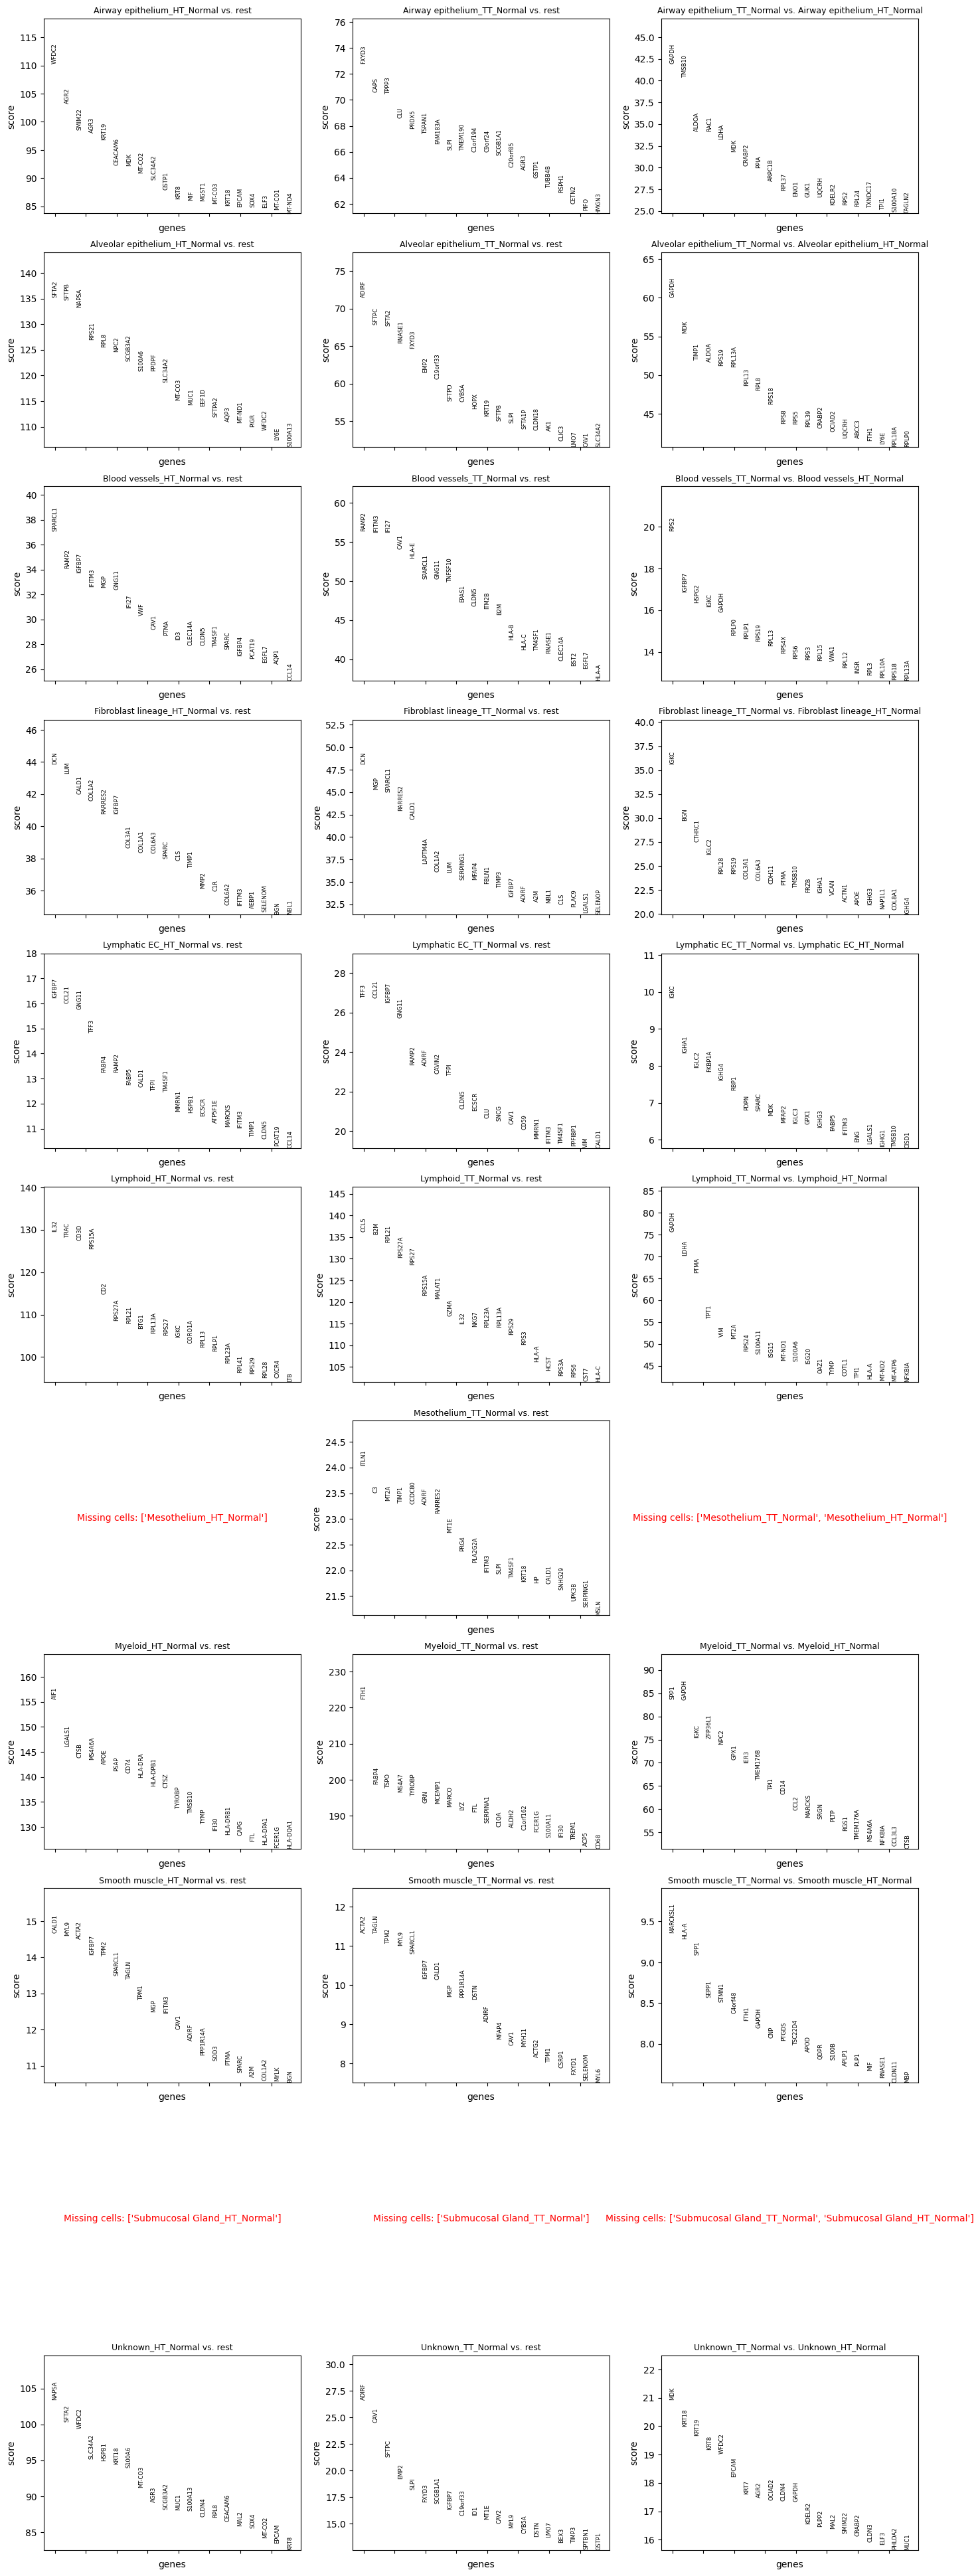

In [24]:
from warnings import warn

if(adata.obs.origin.str.contains('normal').any()):
    fig, axs = plt.subplots(num_types, 3, figsize=(17, 4.5*num_types))
    n_genes = 20
    for i, type in enumerate(types):
        normal_healthy = type + '_HT_Normal'
        normal_tumor = type + '_TT_Normal'
        titlesize = 9
        fontsize = 6
    
        
        cond_plot(adata, [normal_healthy], valid_types, n_genes=n_genes,
                         ax= axs[i, 0], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        cond_plot(adata, [normal_tumor], valid_types, n_genes=n_genes,
                                ax= axs[i, 1], sharey=False, key="wilcoxon", show=False,
                         fontsize=fontsize, titlesize=titlesize)
        print(f"w_pair_{type}_normal")
        cond_plot(adata, [normal_tumor, normal_healthy], valid_types, n_genes=n_genes, ax= axs[i, 2],
                                key=f"w_pair_{type}_normal", show=False,
                         fontsize=fontsize, titlesize=titlesize)
    
    # Display the entire figure with all plots
    plt.show()
else:
    warn('No healthy tissue!')
    

## Heatmaps

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: Airway epithelium_HT_Normal, Airway epithelium_HT_Tumor, Airway epithelium_TT_Normal, etc.
var_group_labels: Myeloid_TT_Normal, Myeloid_HT_Normal, Lymphoid_TT_Normal, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


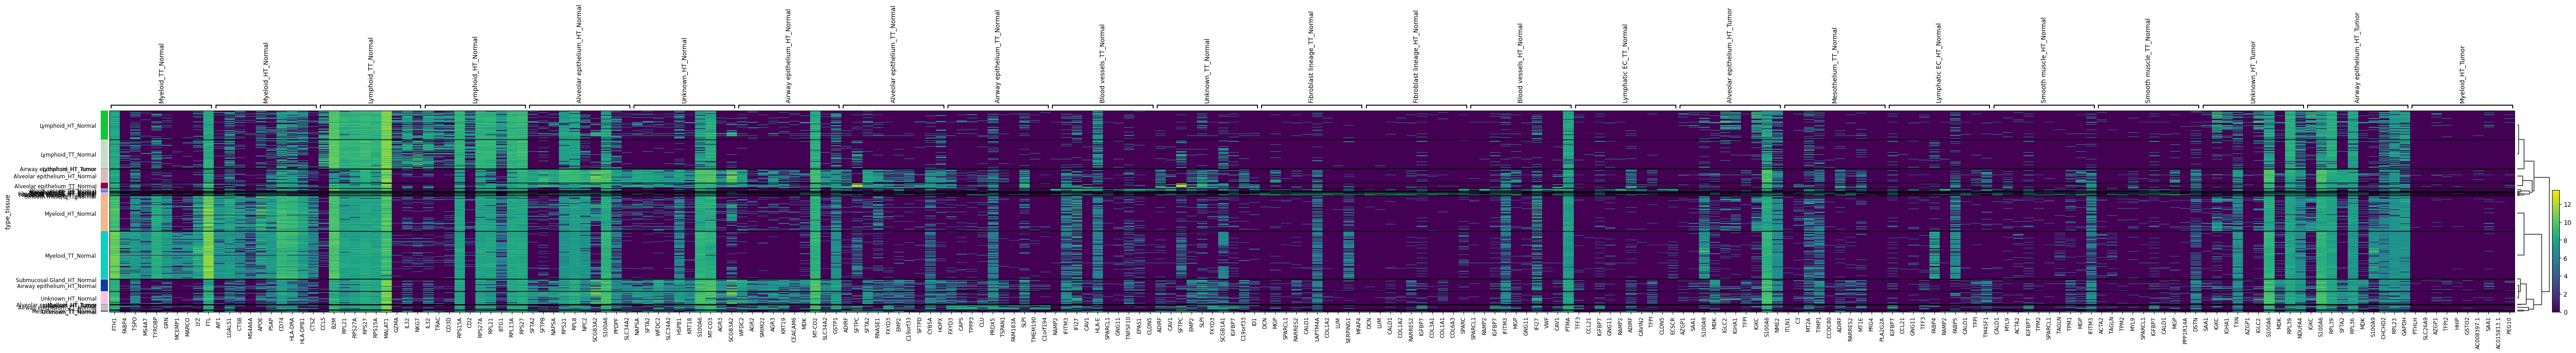

In [25]:
sc.pl.rank_genes_groups_heatmap(adata, show_gene_labels=True, key='wilcoxon')

## GSEA

In [26]:
from gprofiler import GProfiler
import gseapy
import seaborn as sns
gp = GProfiler(return_dataframe=True, user_agent='INMEGEN')

In [27]:
# gen_list = adata.uns['wilcoxon']['names']['Airway epithelium_TT_Tumor'][100:]
# enrich = gp.profile(list(gen_list), sources=['GO:BP'], organism="hsapiens")
# enrich.iloc[:25,:]

In [28]:
#  Download Gene symbols
if not os.path.exists('h.all.v2023.2.Hs.symbols.gmt'):
    ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.symbols.gmt

#  Gene entrez
# if not os.path.exists('h.all.v2023.2.Hs.entrez.gmt'):
# ! wget https://data.broadinstitute.org/gsea-msigdb/msigdb/release/2023.2.Hs/h.all.v2023.2.Hs.entrez.gmt

In [29]:
valid_types = list(adata.obs['type_tissue'].value_counts().loc[lambda x: x > 2].index)

In [30]:
from typing import List

def get_gseas_df(adata: ad.AnnData, valid_types: List[str], types: List[str], id_: str, load_gsea: bool = False) -> pd.DataFrame:
    """
    Generates a combined DataFrame from GSEA results for different cell types.

    Args:
    adata (ad.AnnData): An AnnData object containing the dataset.
    valid_types (List[str]): A list of valid cell types to filter the cell types.
    types (List[str]): A list of cell types to be considered for analysis.
    id_ (str): Identifier used in generating the GSEA path.
    load_gsea (bool, optional): Flag to load existing GSEA results. Defaults to False.

    Returns:
    pd.DataFrame: A combined DataFrame with GSEA results pivoted by cell type and hallmark.

    The function uses the provided 'types', intersects them with 'valid_types',
    and computes GSEA for each type. The final DataFrame is a pivot table with cell types as rows
    and GSEA hallmarks as columns.
    """
    # Intersect types with valid types
    types = set(types).intersection(valid_types)

    gsea_folder = 'gseapy_gsea'
    dfs = []

    for type in types:
        wilco = adata.uns['wilcoxon']
        gsea_path = f'{gsea_folder}/{type}_{id_}.npz'

        # Generate gene scores
        gene_scores = {gene: wilco['scores'][type][i] for i, gene in enumerate(wilco['names'][type])}
        gene_scores = pd.Series(gene_scores)

        # Run GSEA
        if load_gsea:
            gseas = np.load(gsea_path, allow_pickle='TRUE').item()
        else:
            pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
                                     processes=20, permutation_num=100, seed=6, no_plot=True)
            gseas = pre_res.res2d
            np.save(gsea_path, gseas)

        data1 = {'hallmark': list(gseas['Term'].str.slice(9)), 'score': list(gseas['NES'])}
        df_celltype1 = pd.DataFrame(data1)
        df_celltype1['cell_type'] = type
        dfs.append(df_celltype1)

    # Combine all DataFrames
    combined_df = pd.concat(dfs).reset_index(drop=True).pivot(index='cell_type', columns='hallmark', values='score')
    return combined_df

In [31]:
#papermill_description=GSEA
gsea_folder = 'gseapy_gsea'
gsea_path = f'{gsea_folder}/heatmap_{id_}.csv'

if load_gsea_heatmap:
    combined_df = pd.read_csv(gsea_path, index_col=0)
else:
    types = adata.obs.loc[:, 'type_tissue'].unique()
    combined_df = get_gseas_df(adata, valid_types, types, id_, load_gsea=False)
    combined_df.to_csv(gsea_path)

/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:08,850 [WARNING] Duplicated values found in preranked stats: 15.31% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:09,721 [WARNING] Duplicated values found in preranked stats: 41.93% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:10,351 [WARNING] Duplicated values found in preranked stats: 15.63% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:11,099 [WARNING] Duplicated values found in preranked stats: 24.55% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:11,725 [WARNING] Duplicated values found in preranked stats: 46.57% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:12,437 [WARNING] Duplicated values found in preranked stats: 25.59% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:13,080 [WARNING] Duplicated values found in preranked stats: 34.70% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:13,929 [WARNING] Duplicated values found in preranked stats: 26.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:14,554 [WARNING] Duplicated values found in preranked stats: 20.78% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:15,497 [WARNING] Duplicated values found in preranked stats: 34.87% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:16,171 [WARNING] Duplicated values found in preranked stats: 59.75% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:16,790 [WARNING] Duplicated values found in preranked stats: 20.05% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:17,700 [WARNING] Duplicated values found in preranked stats: 44.53% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:18,277 [WARNING] Duplicated values found in preranked stats: 52.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:19,154 [WARNING] Duplicated values found in preranked stats: 38.48% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:19,986 [WARNING] Duplicated values found in preranked stats: 34.81% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:20,809 [WARNING] Duplicated values found in preranked stats: 16.36% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:21,540 [WARNING] Duplicated values found in preranked stats: 54.87% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:22,175 [WARNING] Duplicated values found in preranked stats: 15.43% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:22,902 [WARNING] Duplicated values found in preranked stats: 20.77% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:23,558 [WARNING] Duplicated values found in preranked stats: 31.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:24,369 [WARNING] Duplicated values found in preranked stats: 31.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


/tmp/ipykernel_27778/760898386.py:39: DeprecationWarning: processes is deprecated; use threads
  pre_res = gseapy.prerank(rnk=gene_scores, gene_sets='h.all.v2023.2.Hs.symbols.gmt',
2024-02-21 15:33:25,055 [WARNING] Duplicated values found in preranked stats: 44.09% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [32]:
combined_df

hallmark,ADIPOGENESIS,ALLOGRAFT_REJECTION,ANDROGEN_RESPONSE,ANGIOGENESIS,APICAL_JUNCTION,APICAL_SURFACE,APOPTOSIS,BILE_ACID_METABOLISM,CHOLESTEROL_HOMEOSTASIS,COAGULATION,...,PROTEIN_SECRETION,REACTIVE_OXYGEN_SPECIES_PATHWAY,SPERMATOGENESIS,TGF_BETA_SIGNALING,TNFA_SIGNALING_VIA_NFKB,UNFOLDED_PROTEIN_RESPONSE,UV_RESPONSE_DN,UV_RESPONSE_UP,WNT_BETA_CATENIN_SIGNALING,XENOBIOTIC_METABOLISM
cell_type,,,,,,,,,,,,,,,,,,,,,
Airway epithelium_HT_Normal,1.187222,-1.000000,1.184990,0.803447,0.961892,0.934773,1.083411,1.167683,1.070229,0.940289,...,1.322193,1.013661,1.154238,0.910194,-1.103748,1.186059,1.213826,1.005261,1.011864,1.105579
Airway epithelium_HT_Tumor,-1.092066,-1.239498,-1.113850,-1.288211,-1.126778,-0.652293,-0.992940,-0.822267,-1.196932,-1.254886,...,-1.259028,-0.763016,-0.779885,-1.377542,-1.261662,-1.183573,-1.046998,-1.331317,-0.938867,-1.256769
Airway epithelium_TT_Normal,0.831850,-2.318929,0.878370,-1.196950,-1.365093,0.705734,0.830110,1.374640,0.957489,-1.072118,...,0.950250,0.736219,1.511450,-0.891698,-1.569870,0.725768,1.379928,0.747729,0.991556,1.000501
Alveolar epithelium_HT_Normal,-1.157500,-1.707851,0.959945,-0.883105,-1.095817,0.981465,-0.835774,-0.903937,0.893175,-1.159665,...,-1.020254,-1.010730,-0.694177,-1.208476,-1.024637,-0.868117,0.937035,1.016721,-0.692949,-1.116854
Alveolar epithelium_HT_Tumor,1.092553,0.634376,1.018413,0.698784,0.973069,1.086112,1.054145,1.058135,0.843806,1.032676,...,1.254592,1.137503,1.062107,0.717847,0.667085,1.208447,0.997365,0.940727,0.989645,1.125977
Alveolar epithelium_TT_Normal,-1.013841,-1.715014,1.250076,-1.178819,-0.954521,-0.971669,-1.003572,1.228618,1.290184,-0.927758,...,-0.913696,-1.184474,-0.910911,-0.888279,-1.030749,-1.330743,1.577257,-0.968354,-0.714513,-0.868676
Blood vessels_HT_Normal,-1.239891,-1.503215,-0.964777,1.115893,1.384393,1.015020,-1.001729,-1.343791,-1.425511,1.292465,...,-1.393379,-1.274223,-0.741370,1.455260,-1.246747,-1.334859,1.499881,-1.349347,1.081878,-1.326190
Blood vessels_TT_Normal,-1.071490,-1.135171,-0.972818,-0.652965,-0.720058,-0.787907,-0.868446,-1.149911,-1.263666,-0.767818,...,-1.244167,-1.126706,-0.864118,1.162420,-1.025159,-1.334833,1.077178,-1.098753,-0.598428,-1.084599
Fibroblast lineage_HT_Normal,-1.248601,-1.723051,-0.898800,1.580505,1.416207,1.163928,1.287943,-0.933012,-1.269938,1.718406,...,0.928084,-1.136850,-0.831187,1.215689,-1.277715,1.191676,1.655929,-1.385508,0.928632,0.985175


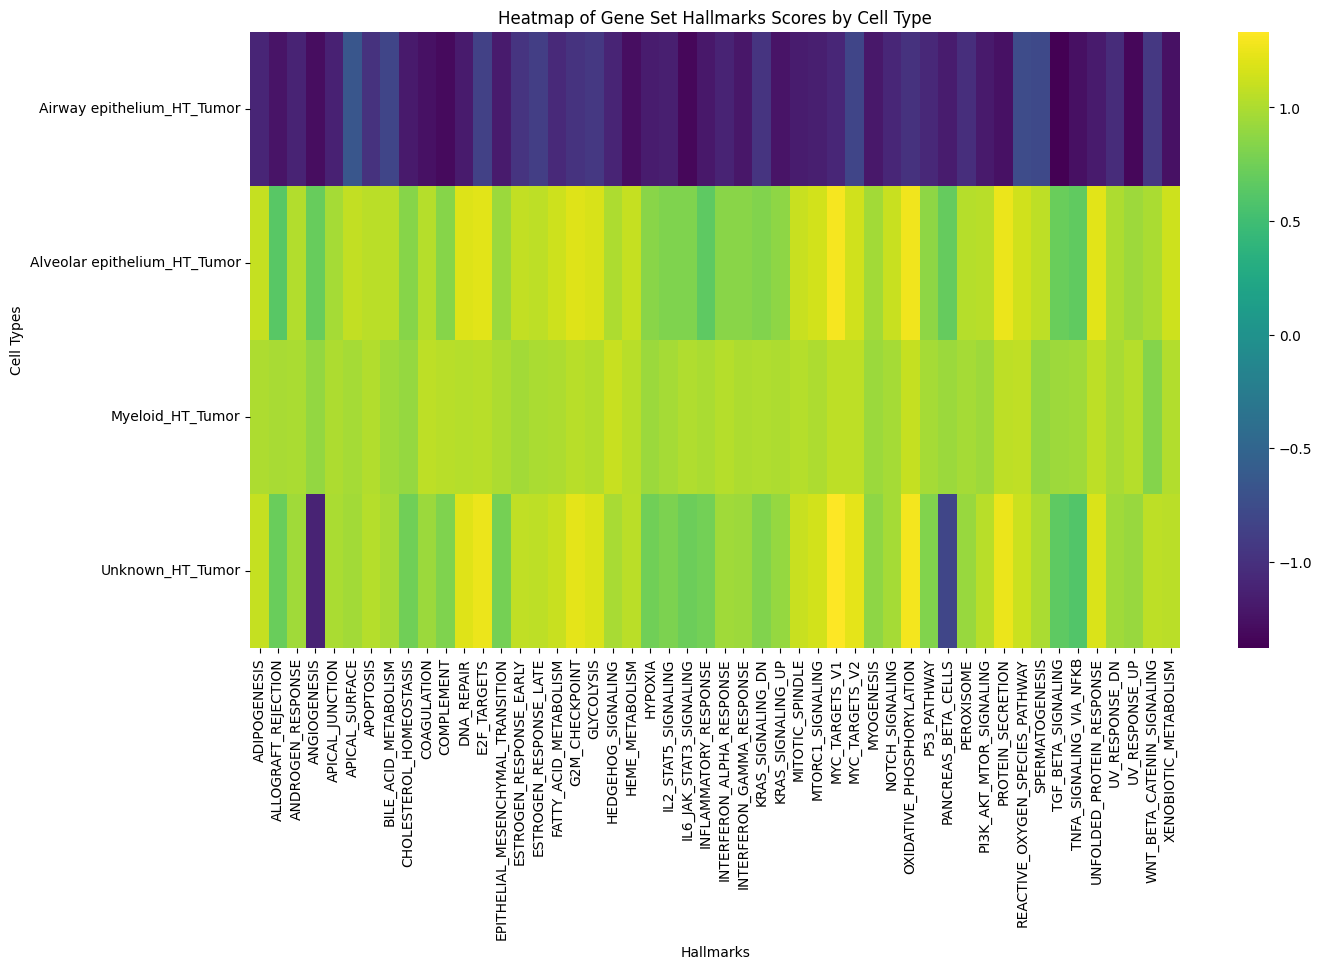

In [33]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Tumor']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df_tumor, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()

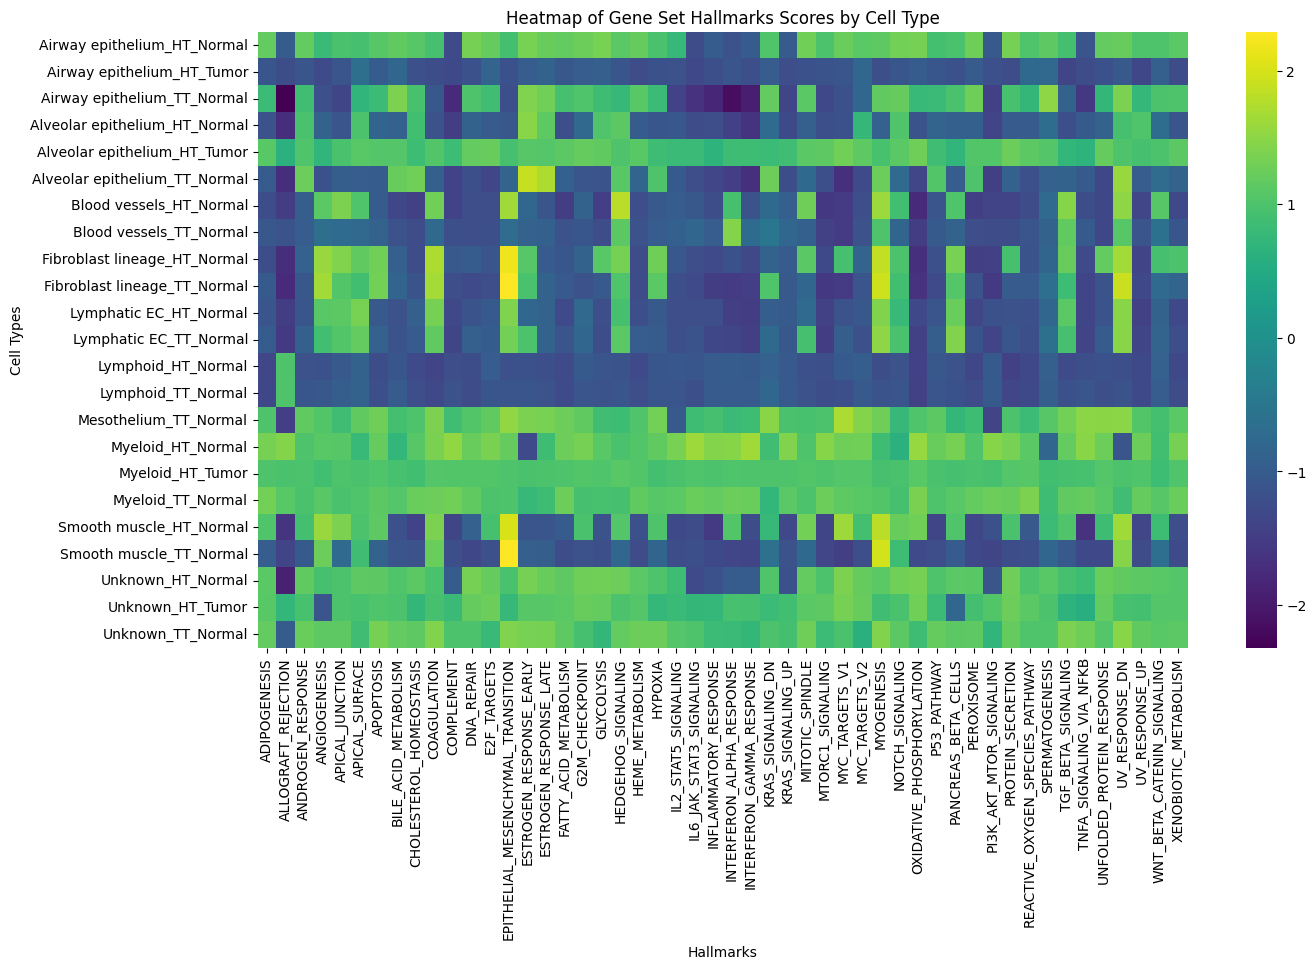

In [34]:
# Plotting the heatmap
combined_df_tumor = combined_df.loc[combined_df.index.str.split('_').str[-1] == 'Normal']

plt.figure(figsize=(15, 8))
sns.heatmap(combined_df, cmap='viridis')
plt.title('Heatmap of Gene Set Hallmarks Scores by Cell Type')
plt.xlabel('Hallmarks')
plt.ylabel('Cell Types')
plt.show()